In [2]:
import cobra
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [3]:
mod1 = cobra.io.load_json_model('./COBRA models/butyrate production/cerevisiaeMod1.json')
mod1a = cobra.io.load_json_model('./COBRA models/butyrate production/cerevisiaeMod1a.json')
mod2 = cobra.io.load_json_model('./COBRA models/butyrate production/cerevisiaeMod2.json')
mod3 = cobra.io.load_json_model('./COBRA models/butyrate production/cerevisiaeMod3.json')

In [4]:
def escherDF(model, lam, name):
    
    modelCopy = model.copy()
    
    biomass = modelCopy.reactions.BIOMASS_SC5_notrace.flux_expression
    but = modelCopy.reactions.DM_but_c.flux_expression
    
    biomass_but = modelCopy.problem.Objective(biomass + lam*but, direction='max')
    modelCopy.objective = biomass_but
    
    solution = modelCopy.optimize(objective_sense=None)
    
    df = pd.DataFrame.from_dict([solution.fluxes]).T
    df.to_csv( name + '.csv')
    
    return(solution)

Two different regimes for each model: 

- 100% butyrate production
- 50% butyrate production

For models 2 and 3 the 100% biomass production regime is studied because these produce butyrate when biomass is optimized. 

<img src="./plots/lambdaBioBut.png">

In [5]:
def solPath(lams, model, biomass, but):
    
    modelCopy = model.copy()
    
    nlams = len(lams)

    buts = np.repeat(0.0, nlams)
    biomasses = np.repeat(0.0, nlams)


    for i, lam in enumerate(lams):

        biomass_but = modelCopy.problem.Objective(biomass + lam*but, direction='max')

        modelCopy.objective = biomass_but

        solution = modelCopy.optimize(objective_sense=None)

        buts[i] = solution.fluxes.DM_but_c

        biomasses[i] = solution.fluxes.BIOMASS_SC5_notrace  
        
    return({'buts' : buts, 'biomasses' : biomasses})
    

In [6]:
lams = np.arange(0, 0.07, 0.001)

In [7]:
biomass = mod1.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod1.reactions.DM_but_c.flux_expression
pathMod1= solPath(lams, mod1, biomass, but)

In [8]:
biomass = mod1a.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod1a.reactions.DM_but_c.flux_expression
pathMod1a= solPath(lams, mod1a, biomass, but)

In [9]:
biomass = mod2.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod2.reactions.DM_but_c.flux_expression
pathMod2 = solPath(lams, mod2, biomass, but)

In [10]:
biomass = mod3.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod3.reactions.DM_but_c.flux_expression
pathMod3= solPath(lams, mod3, biomass, but)

In [11]:
def lamPercentage(path, p):
    
    index = np.argmin( np.abs(path['buts'] - max(path['buts'])*p ))
    
    return(lams[index])


In [12]:
l50Mod1 = lamPercentage(pathMod1, 0.5)
l100Mod1 = lamPercentage(pathMod1, 1)

soll50Mod1 = escherDF(mod1, l50Mod1, 'mod1_b50')
soll100Mod1 = escherDF(mod1, l100Mod1, 'mod1_b100')

In [13]:
l50Mod1a = lamPercentage(pathMod1a, 0.5)
l100Mod1a = lamPercentage(pathMod1a, 1)

soll50Mod1a = escherDF(mod1a, l50Mod1a, 'mod1a_b50')
soll100Mod1a = escherDF(mod1a, l100Mod1a, 'mod1a_b100')

In [14]:
l50Mod2 = lamPercentage(pathMod2, 0.5)
l100Mod2 = lamPercentage(pathMod2, 1)

solBioMod2 = escherDF(mod2, 0, 'mod2_biomass')
soll50Mod2 = escherDF(mod2, l50Mod2, 'mod2_b50')
soll100Mod2 = escherDF(mod2, l100Mod2, 'mod2_b100')

In [15]:
l50Mod3 = lamPercentage(pathMod3, 0.5)
l100Mod3 = lamPercentage(pathMod3, 1)

solBioMod3 = escherDF(mod3, 0, 'mod3_biomass')
soll50Mod3 = escherDF(mod3, l50Mod3, 'mod3_b50')
soll100Mod3 = escherDF(mod3, l100Mod3, 'mod3_b100')

## Flux differences

In [16]:
dfMod1 = pd.DataFrame.from_dict([soll50Mod1.fluxes, soll100Mod1.fluxes]).T
dfMod1.columns = ["but50", "but100"]

dfMod1a = pd.DataFrame.from_dict([soll50Mod1a.fluxes, soll100Mod1a.fluxes]).T
dfMod1a.columns = ["but50", "but100"]

dfMod2 = pd.DataFrame.from_dict([solBioMod2.fluxes, soll50Mod2.fluxes, soll100Mod2.fluxes]).T
dfMod2.columns = ["biomass", "but50", "but100"]

dfMod3 = pd.DataFrame.from_dict([solBioMod3.fluxes, soll50Mod3.fluxes, soll100Mod3.fluxes]).T
dfMod3.columns = ["biomass", "but50", "but100"]

### Some remarks: 

- Only a small fraction of the fluxes are nonzero. 
- The number of nonzero fluxes increases with butyrate production except for model 3. 

In [17]:
(dfMod1 != 0).sum()

but50     331
but100    358
dtype: int64

In [18]:
(dfMod1a != 0).sum()

but50     345
but100    362
dtype: int64

In [19]:
(dfMod2 != 0).sum()

biomass    317
but50      339
but100     393
dtype: int64

In [20]:
(dfMod3 != 0).sum()

biomass    357
but50      340
but100     319
dtype: int64

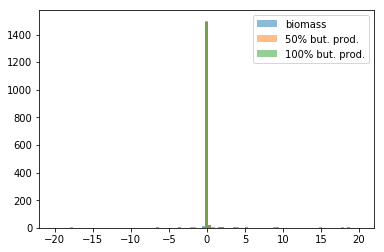

In [21]:
bins = np.linspace(-20, 20, 100)
plt.hist(solBioMod3.fluxes, bins, alpha=0.5, label='biomass')
plt.hist(soll50Mod3.fluxes, bins, alpha=0.5, label='50% but. prod.')
plt.hist(soll50Mod3.fluxes, bins, alpha=0.5, label='100% but. prod.')
plt.legend(loc='upper right')
plt.show()

In [22]:
dfMod1[dfMod1.index == 'DM_but_c']

,but50,but100
DM_but_c,5.556069,7.481328


In [23]:
dfMod1a[dfMod1a.index == 'DM_but_c']

,but50,but100
DM_but_c,5.280294,8.948529


In [24]:
dfMod2[dfMod2.index == 'DM_but_c']

,biomass,but50,but100
DM_but_c,1.052316,5.25408,11.378676


In [25]:
dfMod3[dfMod3.index == 'DM_but_c']

,biomass,but50,but100
DM_but_c,0.457089,5.291694,10.918919


### Flux difference analysis

In [50]:
def matPlot(dfMod, aspect):
    
    dfModCopy = dfMod.copy()
    
    dfModCopy[dfModCopy != 0] = 1
    
    plt.matshow(dfModCopy.values, aspect=aspect)
    plt.show()

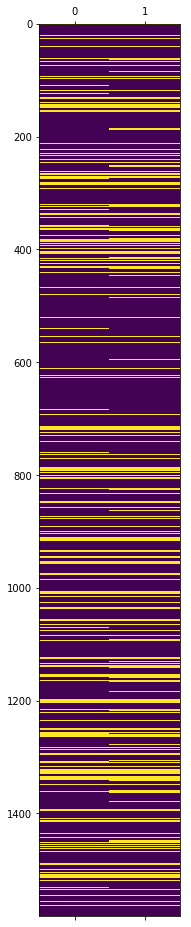

In [51]:
matPlot(dfMod1, 0.008)

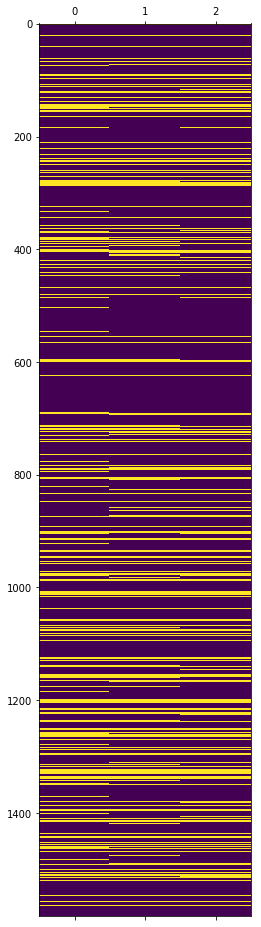

In [52]:
matPlot(dfMod3, 0.008)